In [1]:
import xarray
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from xmovie import Movie
import matplotlib.path as mpath
import cartopy.feature as cft
import numpy as np
import intake 

import warnings
warnings.filterwarnings("ignore") # Suppress warnings for these docs

In [2]:
from xmhw.xmhw import threshold, detect, add_doy, calc_clim

In [2]:
import cosima_cookbook as cc

db = 'local_cc_scratch_0p25_model.db'
session = cc.database.create_session(db)

directory_list=['/g/data/ik11/outputs/access-om2-025/025deg_era5_iaf_1958cycle1']

In [4]:
# directory_list=['/g/data/ik11/outputs/access-om2-025/025deg_era5_iaf_1958cycle1']
# cc.database.build_index(directory_list, session)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42665/status,
Dashboard: /proxy/42665/status,Workers: 14
Total threads: 14,Total memory: 510.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39269,Workers: 14
Dashboard: /proxy/42665/status,Total threads: 14
Started: Just now,Total memory: 510.00 GiB
Comm: tcp://127.0.0.1:34623,Total threads: 1
Dashboard: /proxy/40045/status,Memory: 36.43 GiB
Nanny: tcp://127.0.0.1:33913,


## SST?

In [5]:
import xarray as xr

pattern = "/g/data/ik11/outputs/access-om2-025/025deg_era5_iaf_1958cycle1/output*/ocean/ocean_daily.nc"

def select_sst_only(ds):
    return ds[["sst"]]

ds = xr.open_mfdataset(
    pattern,
    combine="by_coords",        
    parallel=True,              
    preprocess=select_sst_only
)

In [6]:
# ds = cc.querying.getvar(expt='025deg_era5_iaf_1958cycle1', variable='temp', 
#                           session=session, frequency='1 daily',
#                           attrs={'cell_methods': 'time: mean'},
#                           chunks={'xt_ocean': '200MB', 'yt_ocean': '200MB'})

In [7]:
ds = ds.sst
sst = ds - 275.15
sst

<xarray.DataArray 'sst' (time: 24106, yt_ocean: 1080, xt_ocean: 1440)> Size: 150GB
dask.array<sub, shape=(24106, 1080, 1440), dtype=float32, chunksize=(1, 216, 240), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 193kB 1957-12-30T12:00:00 ... 2023-12-29T...

In [8]:
## Only selecting the Southern Ocean portion to reduce the size of the data that must be dealt with
southern_ocean_coverage = sst.sel(yt_ocean = slice(-90,-55))
southern_ocean_coverage


southern_ocean_coverage

<xarray.DataArray 'sst' (time: 24106, yt_ocean: 233, xt_ocean: 1440)> Size: 32GB
dask.array<getitem, shape=(24106, 233, 1440), dtype=float32, chunksize=(1, 216, 240), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 2kB -81.08 -80.97 -80.87 ... -55.28 -55.14
  * time      (time) datetime64[ns] 193kB 1957-12-30T12:00:00 ... 2023-12-29T...

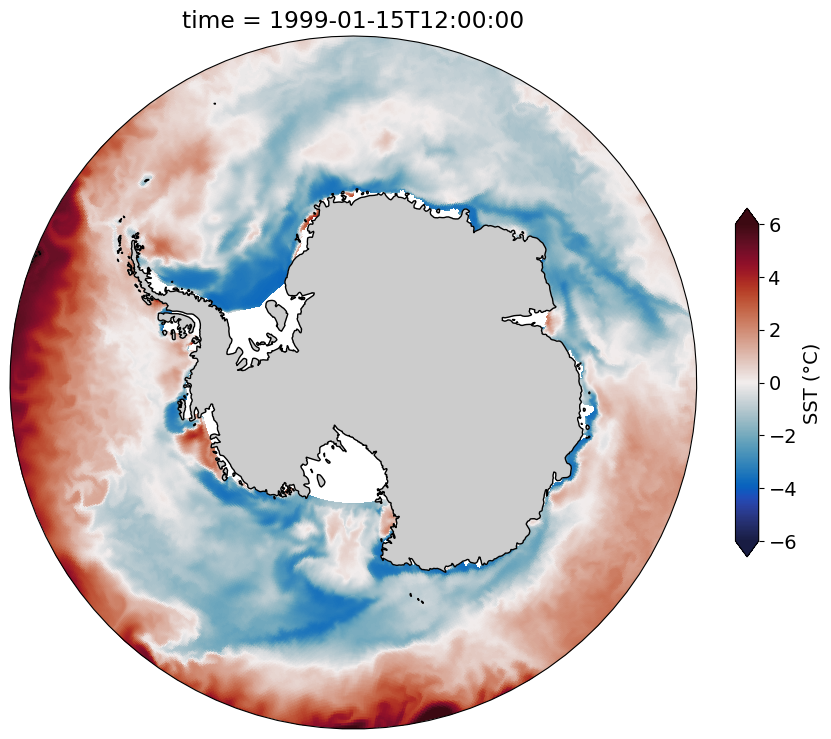

In [26]:
## Plotting the SST data in a Southern Ocean Polar Coordinate system 
%matplotlib inline
projection = ccrs.SouthPolarStereo()
import cartopy.feature as cft

land_50m = cft.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5
)

plt.figure(figsize=(10, 9))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -55], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution="50m")

import matplotlib.path as mpath

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

southern_ocean_coverage.sel(time = '1999-01-15T12:00:00').plot(
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-6,
    vmax=6,
    extend="both",
    cmap=cm.cm.balance,
    cbar_kwargs={"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
    ax = ax
)

plt.show()

In [32]:
import xarray as xr
import numpy as np

def calculate_sst_anomaly_window(
    sst_data,
    tdim="time",
    climatologyPeriod=[None, None],
    windowHalfWidth=5,
    coldSpells=False,
    skipna=False
):
    """
    Calculates daily SST climatology by pooling values within ±windowHalfWidth days.
    Then computes anomalies.

    Args:
        sst_data (xarray.DataArray): SST data with a time coordinate.
        tdim (str): Time dimension name (default 'time').
        climatologyPeriod (list): [start_year, end_year] for baseline climatology.
        windowHalfWidth (int): Half-width (in days) for pooling window (default=5).
        coldSpells (bool): If True, flip SST sign to detect cold anomalies.
        skipna (bool): If True, skip NaNs during mean calculation.

    Returns:
        tuple:
            - xarray.DataArray: Daily climatology (using pooled window).
            - xarray.DataArray: SST anomalies (sst_data - climatology).
    """

    # Subset climatology period if provided
    if all(climatologyPeriod):
        sst_data = sst_data.sel(
            {tdim: slice(f"{climatologyPeriod[0]}-01-01", f"{climatologyPeriod[1]}-12-31")}
        )

    # Add dayofyear coordinate
    sst_data = sst_data.assign_coords(dayofyear=sst_data[tdim].dt.dayofyear)

    # Now build climatology by pooling ±windowHalfWidth days
    clim_list = []
    days_in_year = 366 if sst_data.dayofyear.max() > 365 else 365

    for doy in range(1, days_in_year + 1):
        window_days = np.mod(
            np.arange(doy - windowHalfWidth, doy + windowHalfWidth + 1) - 1, days_in_year
        ) + 1  # Wrap around 1-366
        sst_sel = sst_data.where(sst_data.dayofyear.isin(window_days), drop=True)
        clim_list.append(sst_sel.mean(tdim, skipna=skipna))
    
    climatology = xr.concat(clim_list, dim="dayofyear")
    climatology = climatology.assign_coords(dayofyear=np.arange(1, days_in_year + 1))

    # Calculate anomalies
    anomalies = sst_data.groupby(f"{tdim}.dayofyear") - climatology

    return anomalies

anomalies = calculate_sst_anomaly(southern_ocean_coverage)

In [ ]:
%matplotlib inline
projection = ccrs.SouthPolarStereo()
import cartopy.feature as cft
import cmocean.cm as cm

## Plotting the SST data in a Southern Ocean Polar Coordinate system 
%matplotlib inline
projection = ccrs.SouthPolarStereo()
import cartopy.feature as cft

land_50m = cft.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5
)

plt.figure(figsize=(10, 9))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -55], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution="50m")

import matplotlib.path as mpath

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ssta.sel(time = '1999-01-15T12:00:00').plot(
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-6,
    vmax=6,
    extend="both",
    cmap=cm.cm.balance,
    cbar_kwargs={"label": "SST (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
    ax = ax
)

import matplotlib.path as mpath
import matplotlib.colors as mcolors

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

anomalies.sel(time="2016-02-15").plot(
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-3,
    vmax=3,
    extend="both",
    cmap=cm.balance,
    cbar_kwargs={"label": "SSTA (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
    ax = ax
)

plt.show()

In [78]:
cd "/g/data/e14/ts7341/Temperature_Tendency_Budget/mon_budgets_era5_mlt_tendency_from_snap/0p03_density"

/g/data/e14/ts7341/Temperature_Tendency_Budget/mon_budgets_era5_mlt_tendency_from_snap/0p03_density


In [7]:
cd "/g/data/e14/ts7341/Temperature_Tendency_Budget/mon_budgets_era5_mlt_tendency_from_snap/Test"

/g/data/e14/ts7341/Temperature_Tendency_Budget/mon_budgets_era5_mlt_tendency_from_snap/Test


## MHW Detection

In [ ]:
import xarray as xr

pattern = "/g/data/ik11/outputs/access-om2-025/025deg_era5_iaf_1958cycle1/output*/ocean/ocean_daily.nc"

def select_sst_only(ds):
    return ds[["sst"]]

ds = xr.open_mfdataset(
    pattern,
    combine="by_coords",        
    parallel=True,              
    preprocess=select_sst_only
)

In [ ]:
ds = ds.sel(yt_ocean = slice(-90,-55)).sel(xt_ocean = slice(0,20))
ds = ds.chunk({"time": -1, "yt_ocean": 42, "xt_ocean": 80})

sst_da = ds

In [ ]:
# zarr_path = "/g/data/e14/ts7341/ZARR_TEST/test_zarr"
# ds.to_zarr(zarr_path, mode="w", consolidated=True)

In [ ]:
clim = threshold(sst_da, climatologyPeriod=[1982,2012], tdim ='time')

In [ ]:
clim

In [ ]:
mhw, intermediate = detect(sst_da, clim['thresh'], clim['seas'], tdim ='time', intermediate=True, anynans=True)
mhw

In [ ]:
max_events = mhw.duration.max()
max_indices = np.where(mhw.severity_cumulative == max_events)[0]
max_coords = mhw.isel(events=max_indices)

print("Max severity:", max_events)
print("Indices:", max_indices)
print("Event details at max severity:\n", max_coords)

## Mess

In [ ]:
pattern = '/g/data/e14/ts7341/thresholds_antarctic/Climatology/*nc'

import xarray as xr 

def select_sst_only(ds):
    return ds[["sst"]]

Seas = xr.open_mfdataset(
          pattern,
          combine="by_coords",        
          parallel=True,
          preprocess=select_sst_only
)

In [ ]:
Seas.sst.load()

In [ ]:
import xarray as xr

pattern = "/g/data/ik11/outputs/access-om2-025/025deg_era5_iaf_1958cycle1/output*/ocean/ocean_daily.nc"

def select_sst_only(ds):
    return ds[["sst"]]

ds = xr.open_mfdataset(
    # chunks = {"time": -1, "xt_ocean": 450, "yt_ocean": 720},
    pattern,
    combine="by_coords",        
    parallel=True,              
    preprocess=select_sst_only).sel(time=slice('2015-01-01','2017-12-31'))

ds.coords["st_ocean"] = 0

In [ ]:
ds = ds.sel(yt_ocean = slice(-82,-50)).sel(xt_ocean = slice(-280,80))
print(ds)

In [ ]:
# # Rename dimensions
ds = ds.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})

# # Convert surface_temp from Kelvin to Celsius
ds_input = ds - 273.15
ds_input.attrs['units'] = 'deg C'  # Update units attribute

# # Display the modified dataset structure
ds_input = ds_input.sst

In [ ]:
ds_input = ds_input.assign_coords(dayofyear=ds_input['time'].dt.dayofyear)
print(ds_input)

In [ ]:
import xarray as xr

Seas_aligned = Seas.interp(
    dayofyear=xr.DataArray(ds_input['dayofyear'].values, dims="time")
)


In [ ]:
SSTa = ds_input - Seas_aligned
SSTa = SSTa
print(SSTa)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean.cm as cm
import matplotlib.path as mpath

# --- Set up projection and figure ---
projection = ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(10, 9))
ax = plt.axes(projection=projection)

# --- Map extent and features ---
ax.set_extent([-280, 80, -80, -55], crs=ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature("physical", "land", "50m",
                                   edgecolor="black", facecolor="papayawhip", linewidth=0.5)
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution="50m")

# --- Circular boundary for polar projection ---
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# # --- Plot SST Anomaly background ---
# SSTa_sample = SSTa.sel(time=slice("2022-01-01", "2022-01-31")).mean('time')
# SSTa_sample.plot(
#     x="lon",
#     y="lat",
#     transform=ccrs.PlateCarree(),
#     vmin=-3,
#     vmax=3,
#     cmap=cm.balance,
#     extend="both",
#     cbar_kwargs={"label": "SSTA (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
#     ax=ax
# )

# # --- Plot SIC edge points with line segments connecting only close neighbors ---

# import numpy as np
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs

# month = 'Dec'

# mask = xr.open_dataset(f'/g/data/e14/ts7341/thresholds_antarctic/Ice Edge/{month}_ice_edge_0.2.nc')
# mask_float = mask
# mask_float

# # Assume lons and lats are your 1D numpy arrays
# lons = mask_float['lon'].values
# lats = mask_float['lat'].values

# # Set distance threshold (in degrees — tune this)
# threshold = 0.3  # degrees

# # Loop through the points and draw lines if close enough
# for i in range(len(lons) - 1):
#     lon1, lat1 = lons[i], lats[i]
#     lon2, lat2 = lons[i+1], lats[i+1]
    
#     # Compute distance in degrees
#     dist = np.sqrt((lon2 - lon1)**2 + (lat2 - lat1)**2)
    
#     if dist < threshold:
#         ax.plot(
#             [lon1, lon2], [lat1, lat2],
#             transform=ccrs.PlateCarree(),
#             color='black', linewidth=1
#         )

# Optional: also scatter the original points
#ax.scatter(lons, lats, transform=ccrs.PlateCarree(), s=2, color='black')
# --- Optional title and legend ---
ax.set_title("Apr 2023 SSTA and Climatological SIC = 0.20 Edge", fontsize=14)
ax.legend(["0.2 SIC Edge"], loc='lower left')

ax.scatter([-175, -160, -160, -175, -175], [-77,-77,-73,-73,-77], transform=ccrs.PlateCarree(), s=10, color='black')
ax.plot([-175, -160, -160, -175, -175], [-77,-77,-73,-73,-77], linewidth=2, transform=ccrs.PlateCarree(), color='black')

plt.show()

In [ ]:
def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """

    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(
        boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[1, ::-1], latitudes[1, ::-1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[:, 1], latitudes[:, 1]]), axis=1
    )
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

In [60]:
geolon_t = xr.open_dataset("/g/data/ik11/grids/ocean_grid_025.nc").geolon_t
geolat_t = xr.open_dataset("/g/data/ik11/grids/ocean_grid_025.nc").geolat_t

In [ ]:
midlon = -40
maxlon = midlon + 30
minlon = midlon - 30
minlat = -80
maxlat = -60
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

lons = geolon_t.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = geolat_t.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

SSTa_sample = SSTa.sel(time = slice('2020-12-01', '2020-12-31')).mean('time')
SSTa_sample.plot(
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-3,
    vmax=3,
    extend="both",
    cmap='RdBu_r',
    cbar_kwargs={"label": "SSTA (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

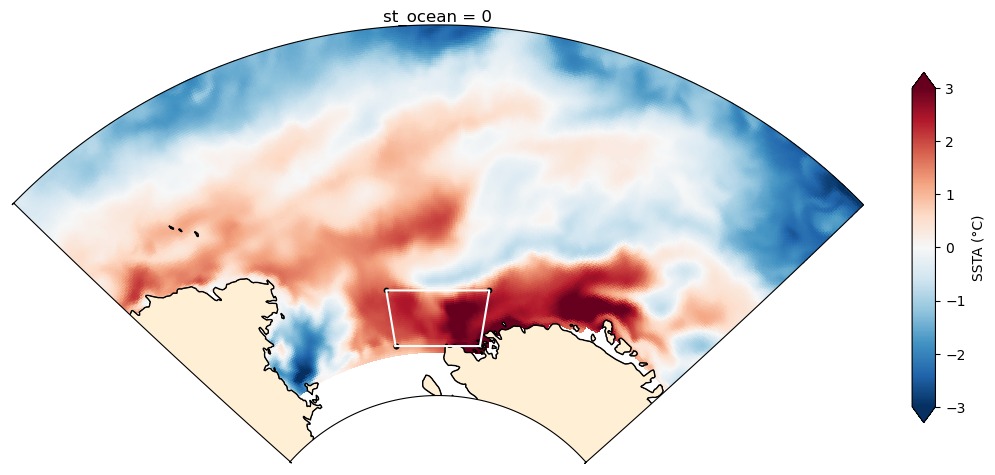

In [93]:
midlon = -160
maxlon = midlon + 50
minlon = midlon - 50
minlat = -80
maxlat = -60
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

lons = geolon_t.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = geolat_t.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

SSTa_sample = SSTa.sel(time = slice('2023-01-01', '2023-01-31')).mean('time')
SSTa_sample.plot(
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-3,
    vmax=3,
    extend="both",
    cmap='RdBu_r',
    cbar_kwargs={"label": "SSTA (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
)

lons = [-170, -150, -150, -170, -170]
lats = [-77,-77,-74,-74,-77]

ax.scatter(lons, lats, transform=ccrs.PlateCarree(), s=10, color='black')
ax.plot(lons, lats, transform=ccrs.PlateCarree(), color='white')

In [11]:
Thresh = xr.open_mfdataset('/g/data/e14/ts7341/thresholds_antarctic/Threshold90pc_combined/*.nc')

In [12]:
Thresh = Thresh.__xarray_dataarray_variable__.load()

In [13]:
Thresh

<xarray.DataArray '__xarray_dataarray_variable__' (lat: 266, lon: 1440,
                                                   dayofyear: 366)> Size: 1GB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [5.69241363, 5.72175746, 5.75125654, ..., 5.61027369,
         5.63603102, 5.66357117],
        [5.30728602, 5.33279803, 5.36012741, ..., 5.24183359,
         5.26321805, 5.28464415],
        [5.01850921, 5.03969736, 5.06274493, ..., 4.96258594,
         4.9812751 , 4.99951054]],

       [[5.23614354, 5.25541008, 5.27476944, ..., 5.17560248,
         5.1961603 , 5.21642358],
        [5.17164858, 5.18656508, 5.20304644, ..., 5.1310287 ,
         5.14340998, 5.15702643],
        [5.36372474, 5.37380676, 5.38442688, ..., 5.33097347,
         5.34238291, 5.3532642 ],
        ...,
        [6.11090757, 6.14291392, 6.17427644, ..., 6.02064416,
         6.04991583, 6.08005647],
        [5.73967128, 5.76619794, 5.79382935, ..., 5.65947906,
         5.68625203, 5.71299941],
        [5.45290744, 5.47573823, 5.49895138, ..., 5.38880182,
         5.41031376, 5.43160164]]])
Coordinates:
  * lon      (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * lat      (lat) float64 2kB -81.08 -80.97 -80.87 ... -50.46 -50.3 -50.14
Dimensions without coordinates: dayofyear

In [14]:
Thresh = Thresh.assign_coords(dayofyear=Thresh['dayofyear'] + 1)
# Check the range of 'dayofyear' in Thresh
print("Thresh dayofyear range:", Thresh['dayofyear'].min().item(), "-", Thresh['dayofyear'].max().item())

Thresh dayofyear range: 1 - 366


In [15]:
Thresh_aligned = Thresh.sel(dayofyear=ds_input['dayofyear'])

In [16]:
print(Thresh_aligned)
SSTa = SSTa.sst

<xarray.DataArray '__xarray_dataarray_variable__' (lat: 266, lon: 1440,
                                                   time: 1096)> Size: 3GB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
         

In [17]:
Seas_aligned = Seas_aligned.sst

In [18]:
Severity = SSTa / (Thresh_aligned - Seas_aligned)

In [19]:
Severity_ds =  xr.Dataset({
    'ssta': SSTa,
    'severity': Severity
}).chunk(dict(time=-1))

In [20]:
Severity_ds

<xarray.Dataset> Size: 7GB
Dimensions:    (lat: 266, lon: 1440, time: 1096)
Coordinates:
  * lat        (lat) float64 2kB -81.08 -80.97 -80.87 ... -50.46 -50.3 -50.14
  * lon        (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
    st_ocean   int64 8B 0
    dayofyear  (time) int64 9kB dask.array<chunksize=(1096,), meta=np.ndarray>
  * time       (time) datetime64[ns] 9kB 2015-01-01T12:00:00 ... 2017-12-31T1...
Data variables:
    ssta       (time, lat, lon) float64 3GB dask.array<chunksize=(1096, 216, 240), meta=np.ndarray>
    severity   (time, lat, lon) float64 3GB dask.array<chunksize=(1096, 216, 240), meta=np.ndarray>

In [21]:
Severity_ds_subset = Severity_ds.sel(time = slice('2015-01-01','2017-12-31'))

print(Severity_ds_subset)

<xarray.Dataset> Size: 7GB
Dimensions:    (lat: 266, lon: 1440, time: 1096)
Coordinates:
  * lat        (lat) float64 2kB -81.08 -80.97 -80.87 ... -50.46 -50.3 -50.14
  * lon        (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
    st_ocean   int64 8B 0
    dayofyear  (time) int64 9kB dask.array<chunksize=(1096,), meta=np.ndarray>
  * time       (time) datetime64[ns] 9kB 2015-01-01T12:00:00 ... 2017-12-31T1...
Data variables:
    ssta       (time, lat, lon) float64 3GB dask.array<chunksize=(1096, 216, 240), meta=np.ndarray>
    severity   (time, lat, lon) float64 3GB dask.array<chunksize=(1096, 216, 240), meta=np.ndarray>


In [22]:
Severity_ds_subset.load()

<xarray.Dataset> Size: 7GB
Dimensions:    (lat: 266, lon: 1440, time: 1096)
Coordinates:
  * lat        (lat) float64 2kB -81.08 -80.97 -80.87 ... -50.46 -50.3 -50.14
  * lon        (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
    st_ocean   int64 8B 0
    dayofyear  (time) int64 9kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * time       (time) datetime64[ns] 9kB 2015-01-01T12:00:00 ... 2017-12-31T1...
Data variables:
    ssta       (time, lat, lon) float64 3GB nan nan nan ... -1.091 -0.8382
    severity   (time, lat, lon) float64 3GB nan nan nan ... -1.235 -0.9505

In [23]:
import sys
sys.path.append('/g/data/e14/ts7341')
import bipolarMhwToolBox as MHW


In [24]:
%%time
mhw = MHW.calculate_MHWs_metrics(Severity_ds_subset, maxEvt=500)

CPU times: user 11min 46s, sys: 1min 9s, total: 12min 56s
Wall time: 11min 41s


In [25]:
print(mhw)

<xarray.Dataset> Size: 708MB
Dimensions:          (lat: 266, lon: 1440, event: 23)
Coordinates:
    st_ocean         int64 8B 0
  * lat              (lat) float64 2kB -81.08 -80.97 -80.87 ... -50.3 -50.14
  * lon              (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * event            (event) int64 184B 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22
Data variables:
    index_start      (lat, lon, event) float64 70MB nan nan nan ... nan nan nan
    index_end        (lat, lon, event) float64 70MB nan nan nan ... nan nan nan
    date_start       (lat, lon, event) datetime64[ns] 70MB NaT NaT ... NaT NaT
    date_end         (lat, lon, event) datetime64[ns] 70MB NaT NaT ... NaT NaT
    duration         (lat, lon, event) float64 70MB nan nan nan ... nan nan nan
    n_event          (lat, lon) int64 3MB 0 0 0 0 0 0 0 0 0 ... 2 2 6 9 6 9 10 9
    index_peak       (lat, lon, event) float64 70MB nan nan nan ... nan nan nan
    date_peak        (lat, lon, event) datetime64[ns] 70MB NaT

In [26]:
mhw.to_netcdf('/g/data/e14/ts7341/thresholds_antarctic/MHW_Stats/2015_2017_MHW_stats.nc')

In [112]:
mhw = xr.open_mfdataset('/g/data/e14/ts7341/thresholds_antarctic/MHW_Stats/2021_2023_MHW_stats.nc')
                         #'/g/data/e14/ts7341/thresholds_antarctic/MHW_Stats/2018_2020_MHW_stats.nc'])

In [113]:
cum = mhw.intensity_cumul
cum = cum.sum('event')

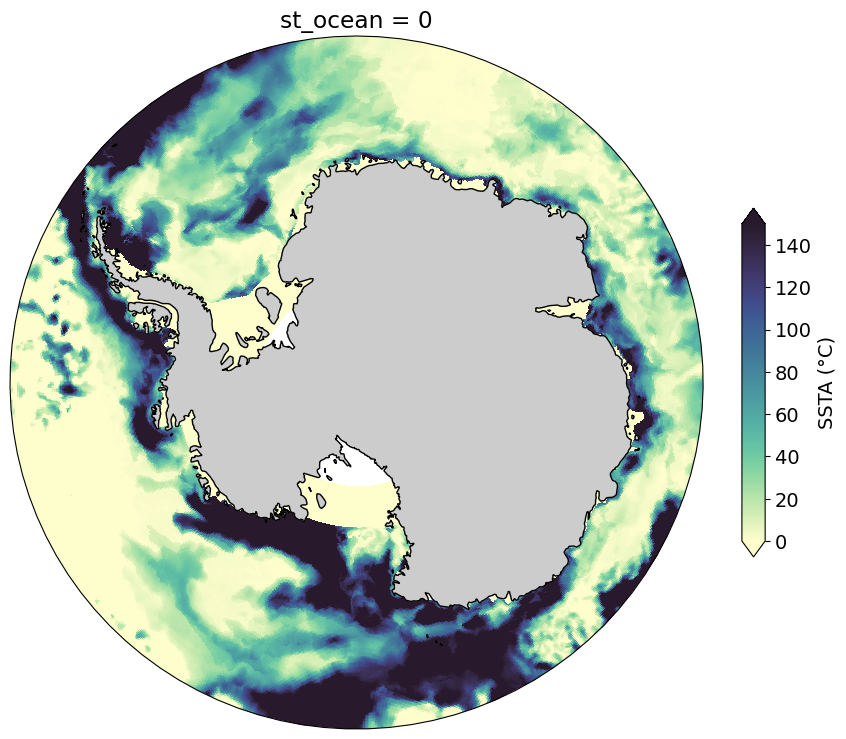

In [114]:
## Plotting the SSTA data in the Southern Ocean projection
%matplotlib inline

import cartopy.feature as cft
import cartopy.crs as ccrs

import warnings
import netCDF4
import cmocean.cm as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from xmovie import Movie
import matplotlib.path as mpath
import numpy as np

projection = ccrs.SouthPolarStereo()

land_50m = cft.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5
)

plt.figure(figsize=(10, 9))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -82, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution="50m")

import matplotlib.path as mpath

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

cum.plot(
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=150,
    extend='both',
    cmap=cm.deep,
    cbar_kwargs={"label": "SSTA (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
    ax = ax
)

plt.show()

In [111]:
sev = Severity.sel(lat=slice(-74.5,-70),lon=slice(-165,-140)).sel(time = slice('2000-01-01', '2023-05-31')).mean('lat').mean('lon')
sev = sev.sst.load()

AttributeError: 'DataArray' object has no attribute 'sst'

In [44]:
sev

NameError: name 'sev' is not defined

In [ ]:
print(SSTa)
ssta = SSTa.sel(lat=slice(-74.5,-70),lon=slice(-165,-140)).sel(time = slice('2000-01-01', '2023-05-31')).mean('lat').mean('lon')
print(ssta)

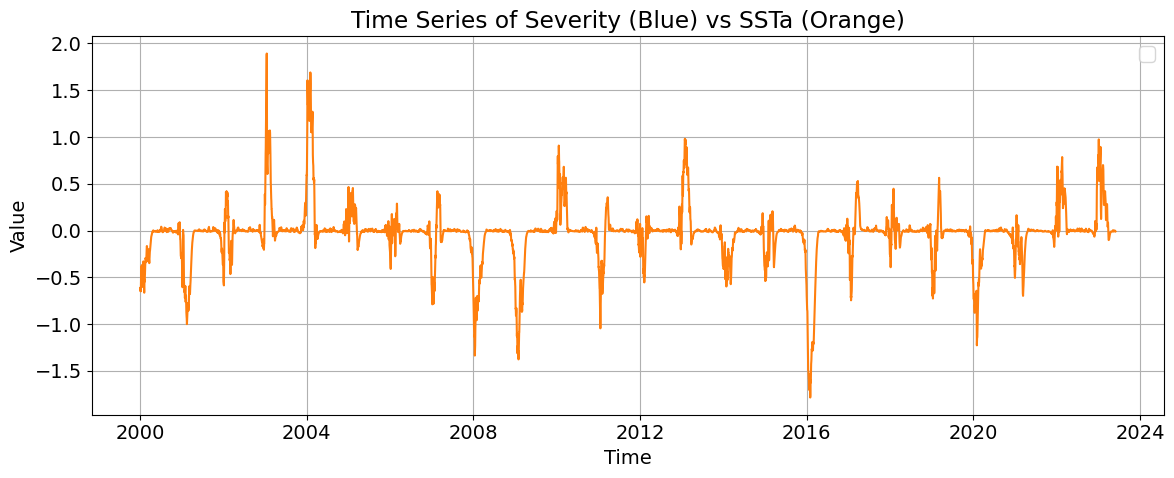

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sev.plot()
ssta.plot()

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series of Severity (Blue) vs SSTa (Orange)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## XMHW Detect

In [1]:
import xarray as xr

pattern = "/g/data/ik11/outputs/access-om2-025/025deg_era5_iaf_1958cycle1/output*/ocean/ocean_daily.nc"

def select_sst_only(ds):
    return ds[["sst"]]

ds = xr.open_mfdataset(
    pattern,
    combine="by_coords",        
    parallel=True,              
    preprocess=select_sst_only
)

In [3]:
antarctic = ds.sel(yt_ocean = slice(-82,-60), xt_ocean = slice(-185,-195))
antarctic_sst = antarctic.sst - 273.15

In [4]:
antarctic_sst.load()

<xarray.DataArray 'sst' (time: 24106, yt_ocean: 196, xt_ocean: 0)> Size: 0B
array([], shape=(24106, 196, 0), dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 0B 
  * yt_ocean  (yt_ocean) float64 2kB -81.08 -80.97 -80.87 ... -60.21 -60.08
  * time      (time) datetime64[ns] 193kB 1957-12-30T12:00:00 ... 2023-12-29T...

In [5]:
from xmhw.xmhw import threshold, detect, add_doy, calc_clim

In [8]:
import time

start_time = time.time()

clim = threshold(antarctic_sst, climatologyPeriod=[1982, 2011])

end_time = time.time()

wall_time = end_time - start_time
print(f"Wall time: {wall_time} seconds")

calendar not in keys


KeyboardInterrupt: 

In [ ]:
print(clim)

In [ ]:
clim.persist()

In [ ]:
output_path = '/g/data/e14/ts7341/thresholds_antarctic/XMHW_Values/clim_test.nc'

In [ ]:
import xarray as xr
ds = xr.open_dataset(output_path)
ds

In [ ]:
se = ds['seas']
th = ds['thresh']

In [ ]:
mhw = detect(antarctic, se, th)

In [ ]:
mhw
output_path = '/g/data/e14/ts7341/thresholds_antarctic/XMHW_Values/xmhw_stats_82_60_lat_0_30_lon.nc'
mhw.to_netcdf(output_path)

In [ ]:
ds = xr.open_dataset(output_path)
mhw = ds 
mhw = mhw.isel(events = slice(5000,9591))

In [ ]:
max_cumulative_intensity = mhw.severity_cumulative.max(dim='events', skipna=True)
max_cumulative_intensity


In [ ]:
intensity = (mhw['severity_cumulative'])

max_val = intensity.max(skipna=True)



In [ ]:
loc = intensity.where(intensity == max_val).stack(z=('events', 'xt_ocean', 'yt_ocean')).dropna('z')

coords = loc.isel(z=0)
event_idx = coords['events'].item()
x_coord = coords['lon'].item()
y_coord = coords['lat'].item()

print(x_coord)
print(y_coord)

In [ ]:
event_idx = int(coords['events'].item())
x_val = coords['lon'].item()
y_val = coords['lat'].item()

# Select the event times
time_start = mhw['time_start'].sel(events=event_idx, lon=x_val, lat=y_val)
time_peak = mhw['time_peak'].sel(events=event_idx, lon=x_val, lat=y_val)
time_end = mhw['time_end'].sel(events=event_idx, lon=x_val, lat=y_val)



print("Start:", time_start.item())
print("Peak:", time_peak.item())
print("End:", time_end.item())

import pandas as pd

# Convert nanoseconds to datetime
start_time = pd.to_datetime(1126008000000000000)
peak_time = pd.to_datetime(1127736000000000000)
end_time = pd.to_datetime(1146398400000000000)

print("Start:", start_time)
print("Peak:", peak_time)
print("End:", end_time)


In [ ]:
seasonal = se.sel(yt_ocean = -63, method = 'nearest').sel(xt_ocean = 2.5, method = 'nearest')
thresh = th.sel(yt_ocean = -63, method = 'nearest').sel(xt_ocean = 2.5, method = 'nearest')

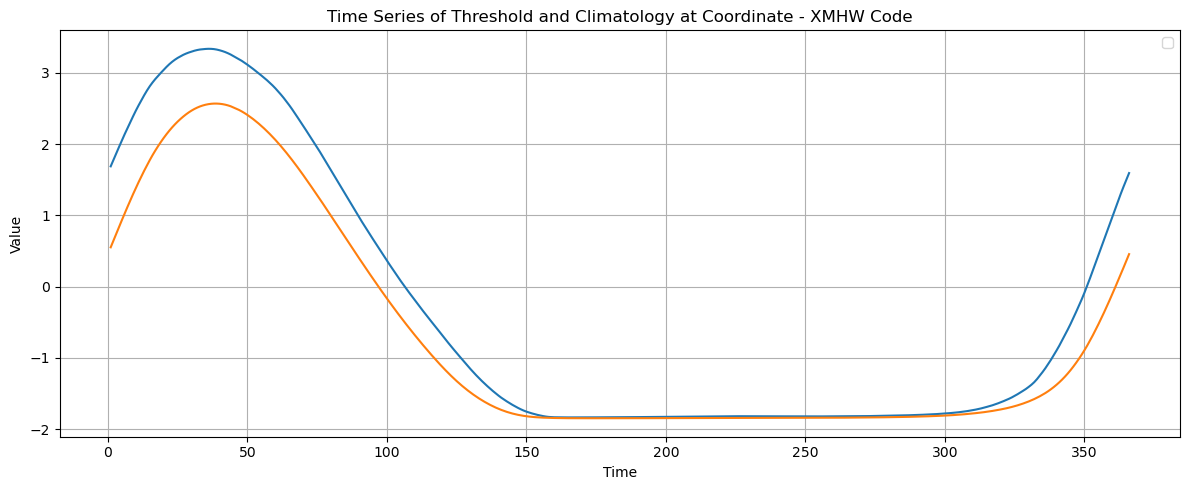

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

thresh.plot()
seasonal.plot()

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series of Threshold and Climatology at Coordinate - XMHW Code')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
import cosima_cookbook as cc

db = 'local_scratch_0p25_model.db'
session = cc.database.create_session(db)

directory_list=['/g/data/ik11/outputs/access-om2-025/025deg_era5_iaf_1958cycle1']

import cosima_cookbook as cc
from cosima_cookbook import explore

In [4]:
%%time
from cosima_cookbook import explore
dbx = explore.DatabaseExplorer(session=session)
dbx

CPU times: user 308 ms, sys: 51.8 ms, total: 359 ms
Wall time: 512 ms


DatabaseExplorer(children=(HTML(value='<style>.header p{ line-height: 1.4; margin-bottom: 10px }</style>\n    …